reserach paper :BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding,https://arxiv.org/pdf/1810.04805

**Bidirectional Encoder Representation Transformer**

a transformer based language model published by Google Research Team at 2018, is still gaining attention and being widely applied in Data Science Project today. This is due to the incredible model performance on multiple NLP tasks including question-answering, text tagging and sentence classification

**0.importing important libraries(modules)**

In [1]:
!pip install transformers datasets tokenizers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import torch.nn as nn

In [3]:
import os
from pathlib import Path
import torch
import re
import random
import transformers, datasets
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer
import tqdm
from torch.utils.data import Dataset, DataLoader
import itertools
import math
import torch.nn.functional as F
import numpy as np
from torch.optim import Adam


**1. Getting Data Ready**

In [4]:
!wget http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
!unzip -qq cornell_movie_dialogs_corpus.zip
!rm cornell_movie_dialogs_corpus.zip
!mkdir datasets
!mv cornell\ movie-dialogs\ corpus/movie_conversations.txt ./datasets
!mv cornell\ movie-dialogs\ corpus/movie_lines.txt ./datasets

--2024-11-12 07:47:52--  http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.53
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.53|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip [following]
--2024-11-12 07:47:52--  https://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9916637 (9.5M) [application/zip]
Saving to: ‘cornell_movie_dialogs_corpus.zip’

cornell_movie_dialo 100%[===================>]   9.46M  10.4MB/s    in 0.9s    

2024-11-12 07:47:54 (10.4 MB/s) - ‘cornell_movie_dialogs_corpus.zip’ saved [9916637/9916637]



In [5]:
MAX_LEN = 64

### loading all data into memory
corpus_movie_conv = './datasets/movie_conversations.txt'
corpus_movie_lines = './datasets/movie_lines.txt'
with open(corpus_movie_conv, 'r', encoding='iso-8859-1') as c:
    conv = c.readlines()
with open(corpus_movie_lines, 'r', encoding='iso-8859-1') as l:
    lines = l.readlines()

### splitting text using special lines
lines_dic = {}
for line in lines:
    objects = line.split(" +++$+++ ")
    lines_dic[objects[0]] = objects[-1]

### generate question answer pairs
pairs = []
for con in conv:
    ids = eval(con.split(" +++$+++ ")[-1])
    for i in range(len(ids)):
        qa_pairs = []

        if i == len(ids) - 1:
            break

        first = lines_dic[ids[i]].strip()
        second = lines_dic[ids[i+1]].strip()

        qa_pairs.append(' '.join(first.split()[:MAX_LEN]))
        qa_pairs.append(' '.join(second.split()[:MAX_LEN]))
        pairs.append(qa_pairs)


In [6]:
print(pairs[20])

["I really, really, really wanna go, but I can't. Not unless my sister goes.", "I'm workin' on it. But she doesn't seem to be goin' for him."]


# **WordPiece Tokenization**

In [7]:
# WordPiece tokenizer

### save data as txt file
os.mkdir('./data')
text_data = []
file_count = 0

for sample in tqdm.tqdm([x[0] for x in pairs]):
    text_data.append(sample)

    # once we hit the 10K mark, save to file
    if len(text_data) == 10000:
        with open(f'./data/text_{file_count}.txt', 'w', encoding='utf-8') as fp:
            fp.write('\n'.join(text_data))
        text_data = []
        file_count += 1

paths = [str(x) for x in Path('./data').glob('**/*.txt')]

### training own tokenizer
tokenizer = BertWordPieceTokenizer(
    clean_text=True,
    handle_chinese_chars=False,
    strip_accents=False,
    lowercase=True
)

tokenizer.train(
    files=paths,
    vocab_size=30_000,
    min_frequency=5,
    limit_alphabet=1000,
    wordpieces_prefix='##',
    special_tokens=['[PAD]', '[CLS]', '[SEP]', '[MASK]', '[UNK]']
    )

os.mkdir('./bert-it-1')
tokenizer.save_model('./bert-it-1', 'bert-it')
tokenizer = BertTokenizer.from_pretrained('./bert-it-1/bert-it-vocab.txt', local_files_only=True)

100%|██████████| 221616/221616 [00:00<00:00, 1263137.06it/s]
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2165: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# **Pre-Training Strategy (Pre-processing)**

1.Masked Language Model (MLM)<br>
2.Next Sentence Prediction (NSP)

In [8]:
class BERTDataset(Dataset):
    def __init__(self, data_pair, tokenizer, seq_len=64):

        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.corpus_lines = len(data_pair)
        self.lines = data_pair

    def __len__(self):
        return self.corpus_lines

    def __getitem__(self, item):

        # Step 1: get random sentence pair, either negative or positive (saved as is_next_label)
        t1, t2, is_next_label = self.get_sent(item)

        # Step 2: replace random words in sentence with mask / random words
        t1_random, t1_label = self.random_word(t1)
        t2_random, t2_label = self.random_word(t2)

        # Step 3: Adding CLS and SEP tokens to the start and end of sentences
         # Adding PAD token for labels
        t1 = [self.tokenizer.vocab['[CLS]']] + t1_random + [self.tokenizer.vocab['[SEP]']]
        t2 = t2_random + [self.tokenizer.vocab['[SEP]']]
        t1_label = [self.tokenizer.vocab['[PAD]']] + t1_label + [self.tokenizer.vocab['[PAD]']]
        t2_label = t2_label + [self.tokenizer.vocab['[PAD]']]

        # Step 4: combine sentence 1 and 2 as one input
        # adding PAD tokens to make the sentence same length as seq_len
        segment_label = ([1 for _ in range(len(t1))] + [2 for _ in range(len(t2))])[:self.seq_len]
        bert_input = (t1 + t2)[:self.seq_len]
        bert_label = (t1_label + t2_label)[:self.seq_len]
        padding = [self.tokenizer.vocab['[PAD]'] for _ in range(self.seq_len - len(bert_input))]
        bert_input.extend(padding), bert_label.extend(padding), segment_label.extend(padding)

        output = {"bert_input": bert_input,
                  "bert_label": bert_label,
                  "segment_label": segment_label,
                  "is_next": is_next_label}

        return {key: torch.tensor(value) for key, value in output.items()}

    def random_word(self, sentence):
        tokens = sentence.split()
        output_label = []
        output = []

        # 15% of the tokens would be replaced
        for i, token in enumerate(tokens):
            prob = random.random()

            # remove cls and sep token
            token_id = self.tokenizer(token)['input_ids'][1:-1]

            if prob < 0.15:
                prob /= 0.15

                # 80% chance change token to mask token
                if prob < 0.8:
                    for i in range(len(token_id)):
                        output.append(self.tokenizer.vocab['[MASK]'])

                # 10% chance change token to random token
                elif prob < 0.9:
                    for i in range(len(token_id)):
                        output.append(random.randrange(len(self.tokenizer.vocab)))

                # 10% chance change token to current token
                else:
                    output.append(token_id)

                output_label.append(token_id)

            else:
                output.append(token_id)
                for i in range(len(token_id)):
                    output_label.append(0)

        # flattening
        output = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output]))
        output_label = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output_label]))
        assert len(output) == len(output_label)
        return output, output_label

    def get_sent(self, index):
        '''return random sentence pair'''
        t1, t2 = self.get_corpus_line(index)

        # negative or positive pair, for next sentence prediction
        if random.random() > 0.5:
            return t1, t2, 1
        else:
            return t1, self.get_random_line(), 0

    def get_corpus_line(self, item):
        '''return sentence pair'''
        return self.lines[item][0], self.lines[item][1]

    def get_random_line(self):
        '''return random single sentence'''
        return self.lines[random.randrange(len(self.lines))][1]

In [9]:
train_data = BERTDataset(
   pairs, seq_len=MAX_LEN, tokenizer=tokenizer)
train_loader = DataLoader(
   train_data, batch_size=32, shuffle=True, pin_memory=True)
sample_data = next(iter(train_loader))
print(train_data[random.randrange(len(train_data))])

{'bert_input': tensor([   1,  366,   15, 2582,   17,    2, 3675, 6839,  520,   17,    2,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]), 'bert_label': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'segment_label': tensor([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'is_next': tensor(0)}


**Embedding**

In [10]:
class PositionalEmbedding(torch.nn.Module):

    def __init__(self, d_model, max_len=128):
        super().__init__()

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        for pos in range(max_len):
            # for each dimension of the each position
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))

        # include the batch size
        self.pe = pe.unsqueeze(0)
        # self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe

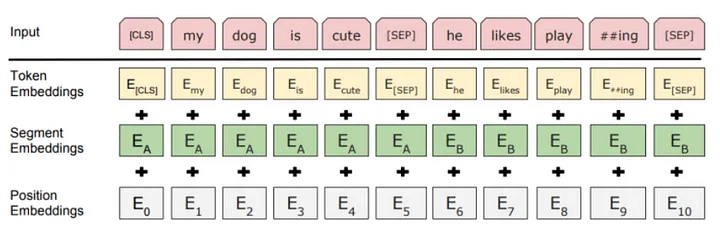

In [11]:
class BERTEmbedding(nn.Module):
    """
    BERT Embedding which is consisted with under features
        1. TokenEmbedding : normal embedding matrix
        2. PositionalEmbedding : adding positional information using sin, cos
        2. SegmentEmbedding : adding sentence segment info, (sent_A:1, sent_B:2)
        sum of all these features are output of BERTEmbedding
    """

    def __init__(self, vocab_size, embed_size, seq_len=64, dropout=0.1):
        """
        :param vocab_size: total vocab size
        :param embed_size: embedding size of token embedding
        :param dropout: dropout rate
        """

        super().__init__()
        self.embed_size = embed_size
        # (m, seq_len) --> (m, seq_len, embed_size)
        # padding_idx is not updated during training, remains as fixed pad (0)
        self.token = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.segment = nn.Embedding(3, embed_size, padding_idx=0)
        self.position = PositionalEmbedding(d_model=embed_size, max_len=seq_len)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, sequence, segment_label):
        x = self.token(sequence) + self.position(sequence) + self.segment(segment_label)
        return self.dropout(x)

# **BERT Architecture**

In [12]:
### attention layers
class MultiHeadedAttention(torch.nn.Module):

    def __init__(self, heads, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()

        assert d_model % heads == 0
        self.d_k = d_model // heads
        self.heads = heads
        self.dropout = torch.nn.Dropout(dropout)

        self.query = torch.nn.Linear(d_model, d_model)
        self.key = torch.nn.Linear(d_model, d_model)
        self.value = torch.nn.Linear(d_model, d_model)
        self.output_linear = torch.nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask):
        """
        query, key, value of shape: (batch_size, max_len, d_model)
        mask of shape: (batch_size, 1, 1, max_words)
        """
        # (batch_size, max_len, d_model)
        query = self.query(query)
        key = self.key(key)
        value = self.value(value)

        # (batch_size, max_len, d_model) --> (batch_size, max_len, h, d_k) --> (batch_size, h, max_len, d_k)
        query = query.view(query.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)
        key = key.view(key.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)
        value = value.view(value.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)

        # (batch_size, h, max_len, d_k) matmul (batch_size, h, d_k, max_len) --> (batch_size, h, max_len, max_len)
        scores = torch.matmul(query, key.permute(0, 1, 3, 2)) / math.sqrt(query.size(-1))

        # fill 0 mask with super small number so it wont affect the softmax weight
        # (batch_size, h, max_len, max_len)
        scores = scores.masked_fill(mask == 0, -1e9)

        # (batch_size, h, max_len, max_len)
        # softmax to put attention weight for all non-pad tokens
        # max_len X max_len matrix of attention
        weights = F.softmax(scores, dim=-1)
        weights = self.dropout(weights)

        # (batch_size, h, max_len, max_len) matmul (batch_size, h, max_len, d_k) --> (batch_size, h, max_len, d_k)
        context = torch.matmul(weights, value)

        # (batch_size, h, max_len, d_k) --> (batch_size, max_len, h, d_k) --> (batch_size, max_len, d_model)
        context = context.permute(0, 2, 1, 3).contiguous().view(context.shape[0], -1, self.heads * self.d_k)

        # (batch_size, max_len, d_model)
        return self.output_linear(context)

In [13]:
class FeedForward(torch.nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, middle_dim=2048, dropout=0.1):
        super(FeedForward, self).__init__()

        self.fc1 = torch.nn.Linear(d_model, middle_dim)
        self.fc2 = torch.nn.Linear(middle_dim, d_model)
        self.dropout = torch.nn.Dropout(dropout)
        self.activation = torch.nn.GELU()

    def forward(self, x):
        out = self.activation(self.fc1(x))
        out = self.fc2(self.dropout(out))
        return out

In [14]:
class EncoderLayer(torch.nn.Module):
    def __init__(
        self,
        d_model=768,
        heads=12,
        feed_forward_hidden=768 * 4,
        dropout=0.1
        ):
        super(EncoderLayer, self).__init__()
        self.layernorm = torch.nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadedAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model, middle_dim=feed_forward_hidden)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, embeddings, mask):
        # embeddings: (batch_size, max_len, d_model)
        # encoder mask: (batch_size, 1, 1, max_len)
        # result: (batch_size, max_len, d_model)
        interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
        # residual layer
        interacted = self.layernorm(interacted + embeddings)
        # bottleneck
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        encoded = self.layernorm(feed_forward_out + interacted)
        return encoded

**Final BERT Model**

In [15]:
class BERT(torch.nn.Module):
    """
    BERT model : Bidirectional Encoder Representations from Transformers.
    """

    def __init__(self, vocab_size, d_model=768, n_layers=12, heads=12, dropout=0.1):
        """
        :param vocab_size: vocab_size of total words
        :param hidden: BERT model hidden size
        :param n_layers: numbers of Transformer blocks(layers)
        :param attn_heads: number of attention heads
        :param dropout: dropout rate
        """

        super().__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.heads = heads

        # paper noted they used 4 * hidden_size for ff_network_hidden_size
        self.feed_forward_hidden = d_model * 4

        # embedding for BERT, sum of positional, segment, token embeddings
        self.embedding = BERTEmbedding(vocab_size=vocab_size, embed_size=d_model)

        # multi-layers transformer blocks, deep network
        self.encoder_blocks = torch.nn.ModuleList(
            [EncoderLayer(d_model, heads, d_model * 4, dropout) for _ in range(n_layers)])

    def forward(self, x, segment_info):
        # attention masking for padded token
        # (batch_size, 1, seq_len, seq_len)
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

        # embedding the indexed sequence to sequence of vectors
        x = self.embedding(x, segment_info)

        # running over multiple transformer blocks
        for encoder in self.encoder_blocks:
            x = encoder.forward(x, mask)
        return x

In [16]:
class NextSentencePrediction(nn.Module):
    """
    2-class classification model : is_next, is_not_next
    """

    def __init__(self, hidden):
        """
        :param hidden: BERT model output size
        """
        super().__init__()
        self.linear = nn.Linear(hidden, 2)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        # use only the first token which is the [CLS]
        return self.softmax(self.linear(x[:, 0]))

In [17]:
class MaskedLanguageModel(nn.Module):
    """
    predicting origin token from masked input sequence
    n-class classification problem, n-class = vocab_size
    """

    def __init__(self, hidden, vocab_size):
        """
        :param hidden: output size of BERT model
        :param vocab_size: total vocab size
        """
        super().__init__()
        self.linear = nn.Linear(hidden, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        return self.softmax(self.linear(x))

In [18]:
class BERTLM(nn.Module):
    """
    BERT Language Model
    Next Sentence Prediction Model + Masked Language Model
    """

    def __init__(self, bert: BERT, vocab_size):
        """
        :param bert: BERT model which should be trained
        :param vocab_size: total vocab size for masked_lm
        """

        super().__init__()
        self.bert = bert
        self.next_sentence = NextSentencePrediction(self.bert.d_model)
        self.mask_lm = MaskedLanguageModel(self.bert.d_model, vocab_size)

    def forward(self, x, segment_label):
        x = self.bert(x, segment_label)
        return self.next_sentence(x), self.mask_lm(x)

**Optimizer**

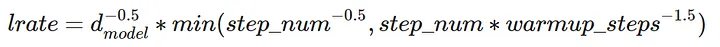

In [19]:
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

**Trainer**

In [20]:
class BERTTrainer:
    def __init__(
        self,
        model,
        train_dataloader,
        test_dataloader=None,
        lr= 1e-4,
        weight_decay=0.01,
        betas=(0.9, 0.999),
        warmup_steps=10000,
        log_freq=10,
        device='cuda'
        ):

        self.device = device
        self.model = model
        self.train_data = train_dataloader
        self.test_data = test_dataloader

        # Setting the Adam optimizer with hyper-param
        self.optim = Adam(self.model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.optim_schedule = ScheduledOptim(
            self.optim, self.model.bert.d_model, n_warmup_steps=warmup_steps
            )

        # Using Negative Log Likelihood Loss function for predicting the masked_token
        self.criterion = torch.nn.NLLLoss(ignore_index=0)
        self.log_freq = log_freq
        print("Total Parameters:", sum([p.nelement() for p in self.model.parameters()]))

    def train(self, epoch):
        self.iteration(epoch, self.train_data)

    def test(self, epoch):
        self.iteration(epoch, self.test_data, train=False)

    def iteration(self, epoch, data_loader, train=True):

        avg_loss = 0.0
        total_correct = 0
        total_element = 0

        mode = "train" if train else "test"

        # progress bar
        data_iter = tqdm.tqdm(
            enumerate(data_loader),
            desc="EP_%s:%d" % (mode, epoch),
            total=len(data_loader),
            bar_format="{l_bar}{r_bar}"
        )

        for i, data in data_iter:

            # 0. batch_data will be sent into the device(GPU or cpu)
            data = {key: value.to(self.device) for key, value in data.items()}

            # 1. forward the next_sentence_prediction and masked_lm model
            next_sent_output, mask_lm_output = self.model.forward(data["bert_input"], data["segment_label"])

            # 2-1. NLL(negative log likelihood) loss of is_next classification result
            next_loss = self.criterion(next_sent_output, data["is_next"])

            # 2-2. NLLLoss of predicting masked token word
            # transpose to (m, vocab_size, seq_len) vs (m, seq_len)
            # criterion(mask_lm_output.view(-1, mask_lm_output.size(-1)), data["bert_label"].view(-1))
            mask_loss = self.criterion(mask_lm_output.transpose(1, 2), data["bert_label"])

            # 2-3. Adding next_loss and mask_loss : 3.4 Pre-training Procedure
            loss = next_loss + mask_loss

            # 3. backward and optimization only in train
            if train:
                self.optim_schedule.zero_grad()
                loss.backward()
                self.optim_schedule.step_and_update_lr()

            # next sentence prediction accuracy
            correct = next_sent_output.argmax(dim=-1).eq(data["is_next"]).sum().item()
            avg_loss += loss.item()
            total_correct += correct
            total_element += data["is_next"].nelement()

            post_fix = {
                "epoch": epoch,
                "iter": i,
                "avg_loss": avg_loss / (i + 1),
                "avg_acc": total_correct / total_element * 100,
                "loss": loss.item()
            }

            if i % self.log_freq == 0:
                data_iter.write(str(post_fix))
        print(
            f"EP{epoch}, {mode}: \
            avg_loss={avg_loss / len(data_iter)}, \
            total_acc={total_correct * 100.0 / total_element}"
        )

if you have good gpu's then you can train it ,but i am going to leave it like this ............

In [21]:
'''test run'''

train_data = BERTDataset(
   pairs, seq_len=MAX_LEN, tokenizer=tokenizer)

train_loader = DataLoader(
   train_data, batch_size=32, shuffle=True, pin_memory=True)

bert_model = BERT(
  vocab_size=len(tokenizer.vocab),
  d_model=768,
  n_layers=2,
  heads=12,
  dropout=0.1
)

bert_lm = BERTLM(bert_model, len(tokenizer.vocab))
bert_trainer = BERTTrainer(bert_lm, train_loader, device='cpu')
epochs = 20

for epoch in range(epochs):
  bert_trainer.train(epoch)

Total Parameters: 46699434


EP_train:0:   0%|| 1/6926 [00:11<22:47:09, 11.85s/it]

{'epoch': 0, 'iter': 0, 'avg_loss': 10.975430488586426, 'avg_acc': 37.5, 'loss': 10.975430488586426}


EP_train:0:   0%|| 11/6926 [02:12<23:05:38, 12.02s/it]

{'epoch': 0, 'iter': 10, 'avg_loss': 10.952547333457254, 'avg_acc': 46.590909090909086, 'loss': 11.07174301147461}


EP_train:0:   0%|| 21/6926 [03:42<17:36:41,  9.18s/it]

{'epoch': 0, 'iter': 20, 'avg_loss': 10.887666338966007, 'avg_acc': 48.214285714285715, 'loss': 10.793018341064453}


EP_train:0:   0%|| 31/6926 [05:10<16:55:11,  8.83s/it]

{'epoch': 0, 'iter': 30, 'avg_loss': 10.80456426066737, 'avg_acc': 49.49596774193548, 'loss': 10.580713272094727}


EP_train:0:   1%|| 41/6926 [06:40<16:48:54,  8.79s/it]

{'epoch': 0, 'iter': 40, 'avg_loss': 10.72569719175013, 'avg_acc': 50.30487804878049, 'loss': 10.440871238708496}


EP_train:0:   1%|| 51/6926 [08:13<18:25:54,  9.65s/it]

{'epoch': 0, 'iter': 50, 'avg_loss': 10.637831295237822, 'avg_acc': 50.245098039215684, 'loss': 10.223061561584473}


EP_train:0:   1%|| 61/6926 [09:44<17:03:54,  8.95s/it]

{'epoch': 0, 'iter': 60, 'avg_loss': 10.560827864975225, 'avg_acc': 50.153688524590166, 'loss': 10.10292911529541}


EP_train:0:   1%|| 71/6926 [11:14<17:13:18,  9.04s/it]

{'epoch': 0, 'iter': 70, 'avg_loss': 10.489285092958262, 'avg_acc': 50.39612676056338, 'loss': 10.013266563415527}


EP_train:0:   1%|| 81/6926 [12:43<16:55:25,  8.90s/it]

{'epoch': 0, 'iter': 80, 'avg_loss': 10.424060256392867, 'avg_acc': 50.3858024691358, 'loss': 9.962837219238281}


EP_train:0:   1%|| 91/6926 [14:13<17:00:17,  8.96s/it]

{'epoch': 0, 'iter': 90, 'avg_loss': 10.363605981344705, 'avg_acc': 50.480769230769226, 'loss': 9.892416954040527}


EP_train:0:   1%|| 97/6926 [15:20<17:59:38,  9.49s/it]


KeyboardInterrupt: 